## CÓDIGOS

In [2]:
import statsmodels.api as sm
from pmdarima import auto_arima
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima.model import ARIMA
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import warnings
from scipy import stats
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import timeseriesmetrics as tss
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from pmdarima import model_selection
import time

import timeseriesmetrics as mt

warnings.filterwarnings('ignore')

# DEFININDO O NOSSO PATH COM OS DADOS
DATA_PATH_TSLA = '../bds/TSLA.csv'

In [3]:
import auxiliar as ax
from sklearn.tree import DecisionTreeRegressor
from skopt.space import Real, Integer
from skopt import gp_minimize
from sklearn.metrics import root_mean_squared_error

In [4]:
TESLA = pd.read_csv(DATA_PATH_TSLA ,sep=',',usecols=[0,4])

significantLags: [1, 5, 8, 10]
          Date       Close   (Close-1)   (Close-5)   (Close-8)  (Close-10)
10  2020-10-15  149.626663  153.766663  141.973328  141.893326  149.386673
11  2020-10-16  146.556671  149.626663  144.666672  137.993332  138.363327


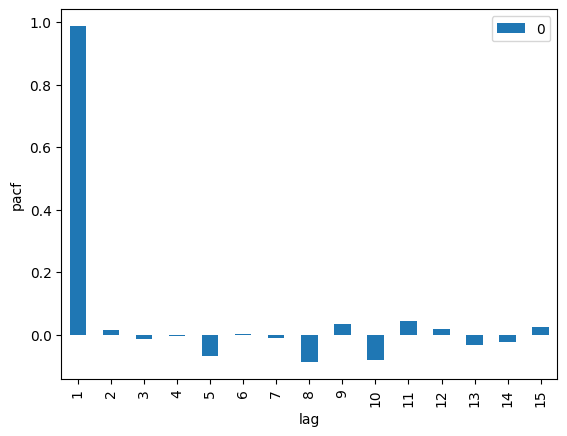

In [5]:
tesla_significantLags = ax.getSignificantLags(y=TESLA['Close'], nLags = 15, alpha=0.05)

TM_tesla = ax.appendLagVariables(yNm='Close', significantLags = tesla_significantLags, df = TESLA, dropna=True)

In [6]:
df_tesla = TM_tesla.dropna()
X = df_tesla.drop('Close', axis=1)
X = X.drop('Date', axis=1)
y = df_tesla['Close']


In [7]:
# Dividir os dados em treino e teste
X_train_tesla, X_test_tesla, y_train_tesla, y_test_tesla = train_test_split(X, y, test_size=0.2, shuffle=False)

# SVD

## REG LIN - > sklearn

In [50]:
start_time = time.time()
model = LinearRegression()
model.fit(X_train_tesla, np.array(y_train_tesla).reshape(-1,1))
y_ajuste_sklearn = model.predict(X_train_tesla)
end_time = time.time()
execution_time_treino = end_time - start_time


In [51]:
execution_time_treino

0.04300498962402344

In [52]:
start_time = time.time()
y_pred_ajuste_sklearn = model.predict(X_test_tesla)
end_time = time.time()
execution_time_previsao = end_time - start_time

In [53]:
execution_time_previsao

0.004005908966064453

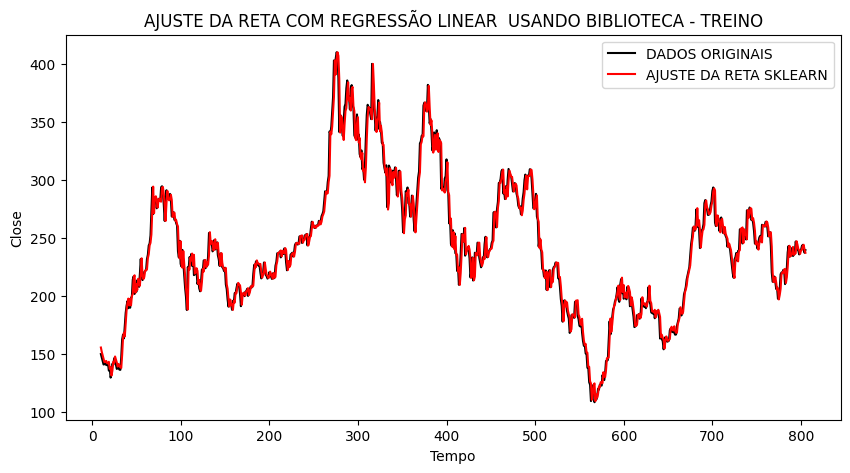

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(X_train_tesla.index, y_train_tesla, label='DADOS ORIGINAIS', color='black')
plt.plot(X_train_tesla.index, y_ajuste_sklearn , label='AJUSTE DA RETA SKLEARN', color='red')
plt.title(f'AJUSTE DA RETA COM REGRESSÃO LINEAR  USANDO BIBLIOTECA - TREINO')
plt.xlabel('Tempo')
plt.ylabel('Close')
plt.legend()
plt.show()
   

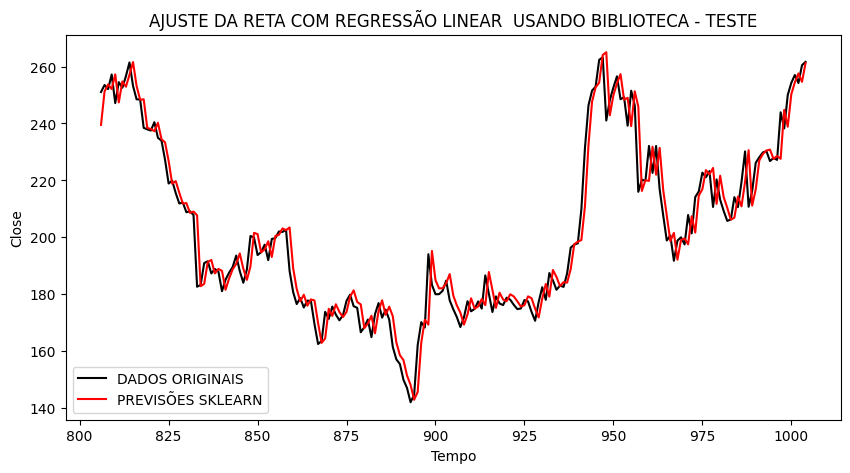

In [11]:
plt.figure(figsize=(10, 5))
plt.plot(X_test_tesla.index, y_test_tesla, label='DADOS ORIGINAIS', color='black')
plt.plot(X_test_tesla.index, y_pred_ajuste_sklearn , label='PREVISÕES SKLEARN', color='red')
plt.title(f'AJUSTE DA RETA COM REGRESSÃO LINEAR  USANDO BIBLIOTECA - TESTE')
plt.xlabel('Tempo')
plt.ylabel('Close')
plt.legend()
plt.show()
   

## REG LIN -> IMPLEMENTAÇÃO SEM SVD

In [12]:
y_train_tesla = np.array(y_train_tesla).reshape(-1, 1)

In [13]:
beta_chape_standard = np.linalg.inv(np.array(X_train_tesla).T @ np.array(X_train_tesla)) @ np.array(X_train_tesla).T @ y_train_tesla

In [14]:
ajuste_reta_sem_skl_sem_svd = X_train_tesla @ beta_chape_standard

In [15]:
previsoes_sem_skl_sem_svd = X_test_tesla @ beta_chape_standard

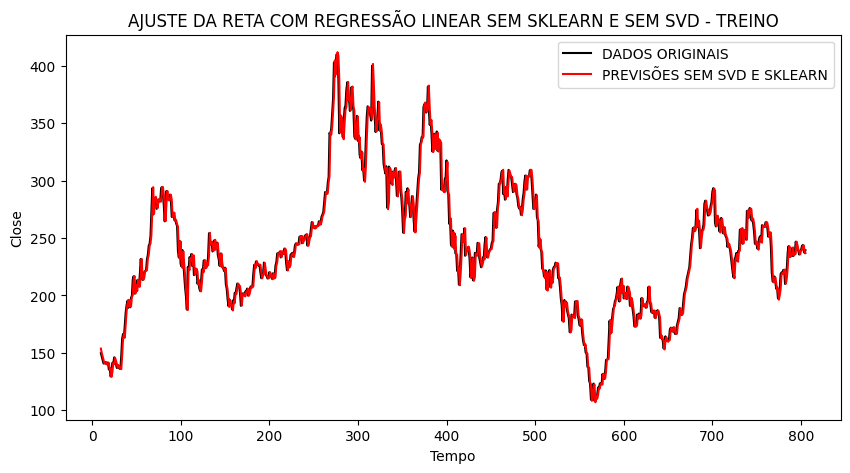

In [16]:
plt.figure(figsize=(10, 5))
plt.plot(X_train_tesla.index, y_train_tesla, label='DADOS ORIGINAIS', color='black')
plt.plot(X_train_tesla.index, ajuste_reta_sem_skl_sem_svd, label='PREVISÕES SEM SVD E SKLEARN', color='red')
plt.title(f'AJUSTE DA RETA COM REGRESSÃO LINEAR SEM SKLEARN E SEM SVD - TREINO')
plt.xlabel('Tempo')
plt.ylabel('Close')
plt.legend()
plt.show()
   

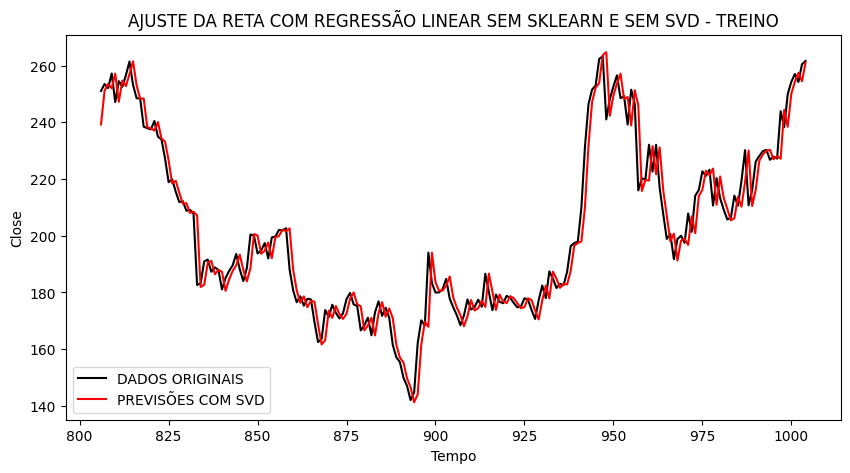

In [17]:
plt.figure(figsize=(10, 5))
plt.plot(X_test_tesla.index, y_test_tesla, label='DADOS ORIGINAIS', color='black')
plt.plot(X_test_tesla.index, previsoes_sem_skl_sem_svd  , label='PREVISÕES COM SVD', color='red')
plt.title(f'AJUSTE DA RETA COM REGRESSÃO LINEAR SEM SKLEARN E SEM SVD - TREINO')
plt.xlabel('Tempo')
plt.ylabel('Close')
plt.legend()
plt.show()
   

## REG LIN UTILIZANDO SVD

In [18]:
start_time = time.time()
U, S, Vt = np.linalg.svd(X_train_tesla, full_matrices=False)

# Mostrando os shapes para depuração
print(f'Shape U: {U.shape}')
print(f'Shape S: {S.shape}')  # S é um vetor
print(f'Shape Vt: {Vt.shape}')

# Criando S_inv como uma matriz diagonal de tamanho p x p
S_inv = np.zeros_like(Vt.T)
for i in range(len(S)):
    if S[i] > 1e-10:  # Para evitar a divisão por zero
        S_inv[i, i] = 1 / S[i]

# Mostrando o shape de S_inv
print(f'Shape S_inv: {S_inv.shape}')

# Certificando-se de que y_train_tesla tem o formato correto (n, 1)
y_train_tesla = np.array(y_train_tesla).reshape(-1, 1)

# Calculando os coeficientes beta
beta_chapel = Vt.T @ S_inv @ U.T @ y_train_tesla
# Fazendo previsões com os coeficientes obtidos
ajuste_reta_com_SVD = X_train_tesla @ beta_chapel
end_time = time.time()
execution_time_treino_com_svd = end_time - start_time


Shape U: (796, 4)
Shape S: (4,)
Shape Vt: (4, 4)
Shape S_inv: (4, 4)


In [19]:
execution_time_treino_com_svd

0.02701258659362793

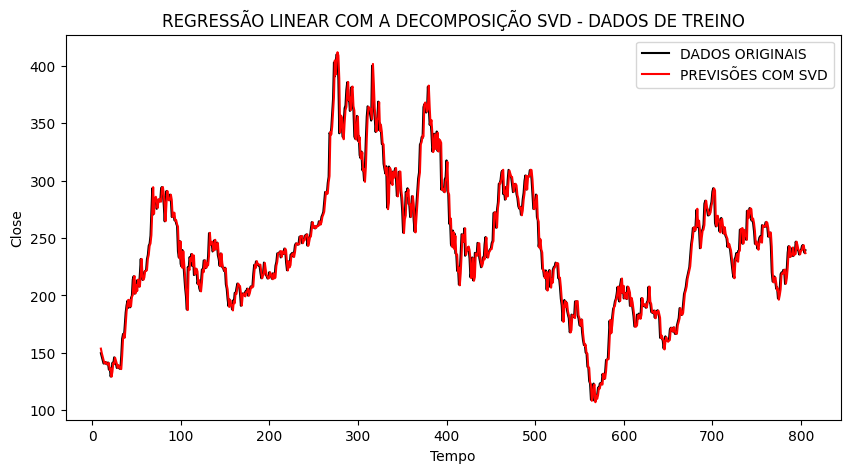

In [20]:
plt.figure(figsize=(10, 5))
plt.plot(X_train_tesla.index, y_train_tesla, label='DADOS ORIGINAIS', color='black')
plt.plot(X_train_tesla.index, ajuste_reta_com_SVD , label='PREVISÕES COM SVD', color='red')
plt.title(f'REGRESSÃO LINEAR COM A DECOMPOSIÇÃO SVD - DADOS DE TREINO')
plt.xlabel('Tempo')
plt.ylabel('Close')
plt.legend()
plt.show()
   

In [21]:
start_time = time.time()
previsoes_com_SVD = X_test_tesla @ beta_chapel
end_time = time.time()
execution_time_previsao_com_svd = end_time - start_time


In [22]:
execution_time_previsao_com_svd

0.0010097026824951172

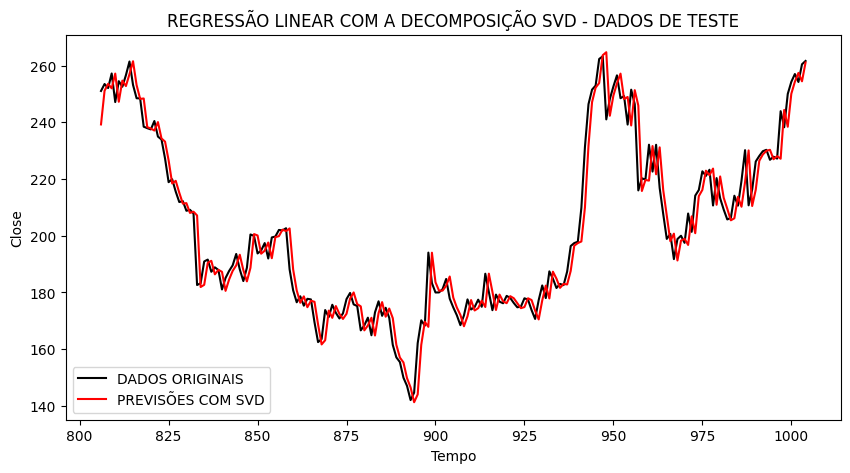

In [23]:
plt.figure(figsize=(10, 5))
plt.plot(X_test_tesla.index, y_test_tesla, label='DADOS ORIGINAIS', color='black')
plt.plot(X_test_tesla.index, previsoes_com_SVD , label='PREVISÕES COM SVD', color='red')
plt.title(f'REGRESSÃO LINEAR COM A DECOMPOSIÇÃO SVD - DADOS DE TESTE')
plt.xlabel('Tempo')
plt.ylabel('Close')
plt.legend()
plt.show()
   

In [24]:
ax.calcular_metricas_regressao(y_test_tesla,previsoes_com_SVD)

,Métrica,Valor
0,MAE,5.290437
1,MSE,53.124278
2,MAPE,0.026164
3,RMSE,7.288640
4,R^2,0.941647
5,THEIL,0.998906
6,ARV,0.058353
7,WPOCID,0.550505


## QR

In [25]:
start_time = time.time()
# Decomposição QR
Q, R = np.linalg.qr(X_train_tesla)

A = Q.T@y_train_tesla

beta = np.linalg.solve(R, A)

ajuste_reta_com_QR = X_train_tesla @ beta

end_time = time.time()
tempo_ajuste_reta_com_QR = end_time - start_time

In [26]:
tempo_ajuste_reta_com_QR 

0.001999378204345703

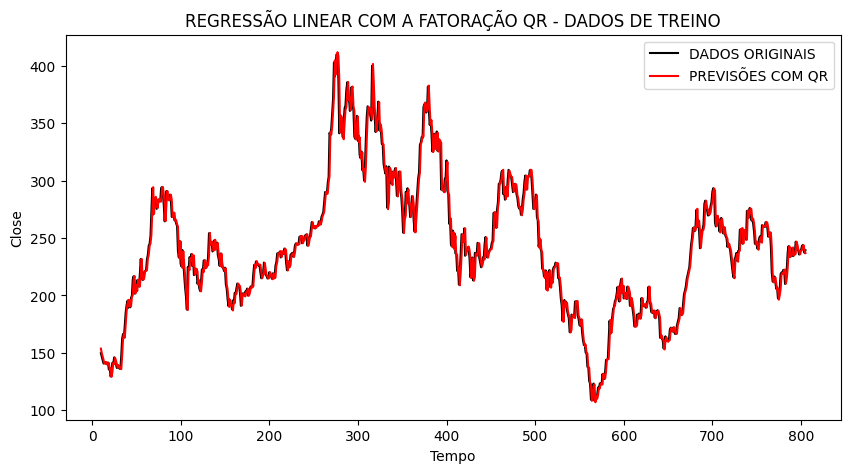

In [27]:
plt.figure(figsize=(10, 5))
plt.plot(X_train_tesla.index, y_train_tesla, label='DADOS ORIGINAIS', color='black')
plt.plot(X_train_tesla.index, ajuste_reta_com_QR , label='PREVISÕES COM QR', color='red')
plt.title(f'REGRESSÃO LINEAR COM A FATORAÇÃO QR - DADOS DE TREINO')
plt.xlabel('Tempo')
plt.ylabel('Close')
plt.legend()
plt.show()
   

In [28]:
start_time = time.time()
previsoes_com_QR = X_test_tesla @ beta

end_time = time.time()
tempo_previsoes_com_QR = end_time - start_time

In [29]:
tempo_previsoes_com_QR

0.0

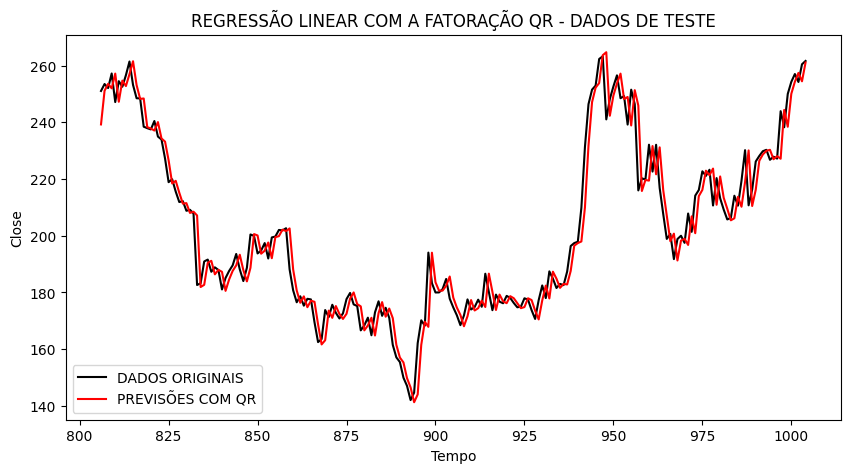

In [30]:
plt.figure(figsize=(10, 5))
plt.plot(X_test_tesla.index, y_test_tesla, label='DADOS ORIGINAIS', color='black')
plt.plot(X_test_tesla.index, previsoes_com_QR , label='PREVISÕES COM QR', color='red')
plt.title(f'REGRESSÃO LINEAR COM A FATORAÇÃO QR - DADOS DE TESTE')
plt.xlabel('Tempo')
plt.ylabel('Close')
plt.legend()
plt.show()
   

In [31]:
ax.calcular_metricas_regressao(y_test_tesla,previsoes_com_QR)

,Métrica,Valor
0,MAE,5.290437
1,MSE,53.124278
2,MAPE,0.026164
3,RMSE,7.288640
4,R^2,0.941647
5,THEIL,0.998906
6,ARV,0.058353
7,WPOCID,0.550505


Exemplo 4.3. Uma matriz ortogonal A é um exemplo de matriz bem condicionada, pois pelo item (d) da
Proposição 4.1.2, cond2(A) = 1 para qualquer norma.

In [32]:
cond_num = np.linalg.cond(X_test_tesla)
print("Número de condição (norma 2):", cond_num)

Número de condição (norma 2): 68.29950693664834


In [33]:
def erro_relativo_medio(valores_verdadeiros, valores_previstos):
    # Calcula o erro relativo para cada par de valores
    erros_relativos = np.abs(np.array(valores_previstos) - np.array(valores_verdadeiros)) / np.abs(valores_verdadeiros)
    # Calcula o erro relativo médio e o erro relativo médio em percentual
    erro_relativo_medio = np.mean(erros_relativos)
    erro_relativo_percentual_medio = erro_relativo_medio * 100
    return erro_relativo_medio, erro_relativo_percentual_medio

## GRADIENTE CONJULGADO

In [34]:
def grad_conj(X, y, beta0=None, eps=1e-5, maxiter=100):
    # Construir a matriz e o vetor do sistema normal
    A = np.dot(X.T, X)
    b = np.dot(X.T, y)

    # Inicializar beta0, se não fornecido
    n = A.shape[1]
    if beta0 is None:
        beta0 = np.zeros(n)
        
    # Inicializar o gradiente e a direção de descida
    grad0 = np.dot(A, beta0) - b
    d = -grad0                      
    iteracao = []
    norma_grad_list = []

    # Iterações do método do gradiente conjugado
    for i in range(maxiter):
        alpha = np.dot(grad0.T, grad0) / np.dot(d.T, np.dot(A, d))
        beta0 = beta0 + alpha * d
        gradi = grad0 + alpha * np.dot(A, d)

        # Imprimir o progresso
        norma_grad = np.linalg.norm(gradi)
        print(f"Iteração {i}: Norma do gradiente = {norma_grad}")
        iteracao.append(i)
        norma_grad_list.append(norma_grad)

        # Verificar a convergência
        if norma_grad < eps:
            return beta0, iteracao, norma_grad_list
        
        # Atualizar betai e grad0
        betai = np.dot(gradi.T, gradi) / np.dot(grad0.T, grad0)
        d = -gradi + betai * d
        grad0 = gradi

    return beta0, iteracao, norma_grad_list

In [35]:
BETA, iteracao, normas = grad_conj(X_train_tesla, y_train_tesla)

Iteração 0: Norma do gradiente = 565788.0348511698
Iteração 1: Norma do gradiente = 60501.59836202137
Iteração 2: Norma do gradiente = 2749.431179006774
Iteração 3: Norma do gradiente = 134.7961549245856
Iteração 4: Norma do gradiente = 7.292054136447169e-09


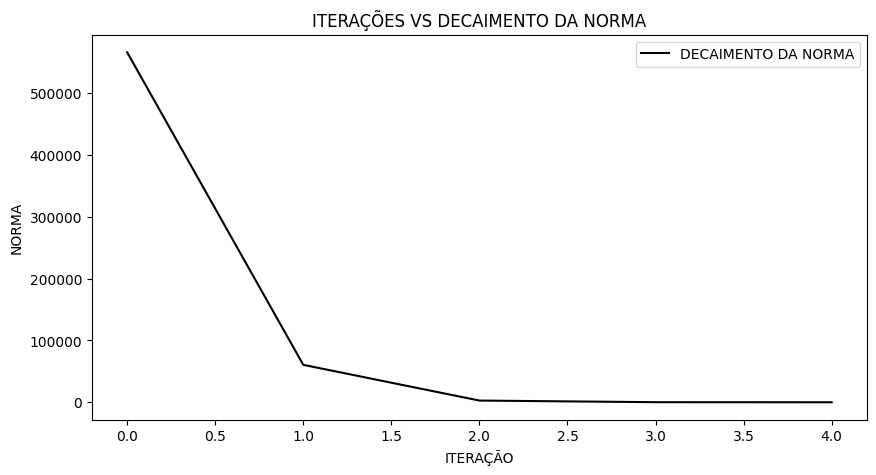

In [36]:
plt.figure(figsize=(10, 5))
plt.plot(iteracao, normas, label='DECAIMENTO DA NORMA', color='black')
plt.title(f'ITERAÇÕES VS DECAIMENTO DA NORMA')
plt.xlabel('ITERAÇÃO')
plt.ylabel('NORMA')
plt.legend()
plt.show()
   

In [37]:
ajuste_reta_com_GC = X_train_tesla @ BETA

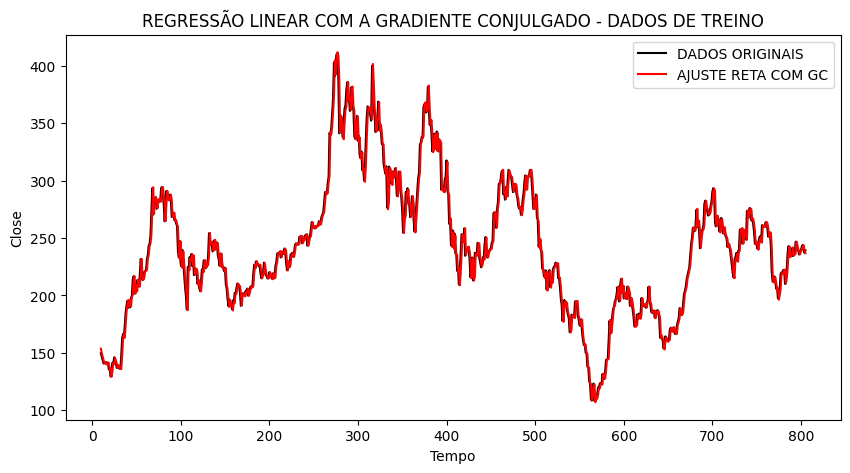

In [38]:
plt.figure(figsize=(10, 5))
plt.plot(X_train_tesla.index, y_train_tesla, label='DADOS ORIGINAIS', color='black')
plt.plot(X_train_tesla.index, ajuste_reta_com_GC[0], label='AJUSTE RETA COM GC', color='red')
plt.title(f'REGRESSÃO LINEAR COM A GRADIENTE CONJULGADO - DADOS DE TREINO')
plt.xlabel('Tempo')
plt.ylabel('Close')
plt.legend()
plt.show()
   

In [39]:
previsoes_com_GC = X_test_tesla @ BETA

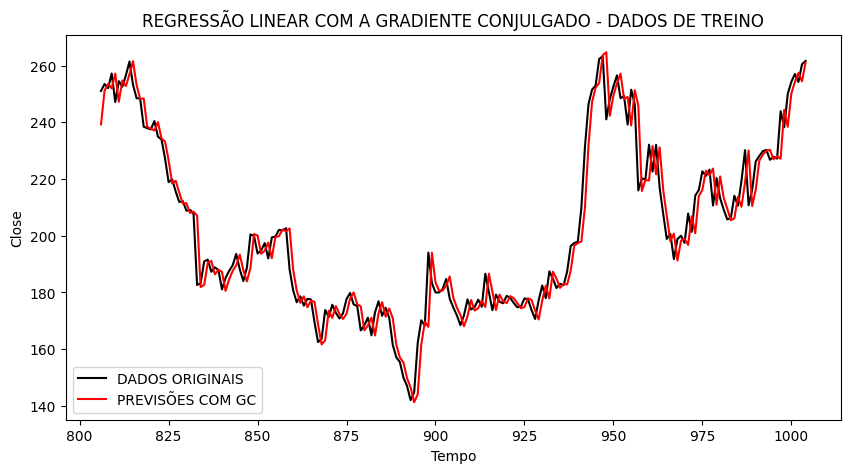

In [40]:
plt.figure(figsize=(10, 5))
plt.plot(X_test_tesla.index, y_test_tesla, label='DADOS ORIGINAIS', color='black')
plt.plot(X_test_tesla.index, previsoes_com_GC[0], label='PREVISÕES COM GC', color='red')
plt.title(f'REGRESSÃO LINEAR COM A GRADIENTE CONJULGADO - DADOS DE TREINO')
plt.xlabel('Tempo')
plt.ylabel('Close')
plt.legend()
plt.show()
   

In [41]:
ax.calcular_metricas_regressao(y_test_tesla,previsoes_com_GC[0])

,Métrica,Valor
0,MAE,5.290437
1,MSE,53.124278
2,MAPE,0.026164
3,RMSE,7.288640
4,R^2,0.941647
5,THEIL,0.998906
6,ARV,0.058353
7,WPOCID,0.550505


In [49]:
ax.calcular_metricas_regressao(y_test_tesla, y_pred_ajuste_sklearn)

,Métrica,Valor
0,MAE,5.297430
1,MSE,52.890635
2,MAPE,0.026347
3,RMSE,7.272595
4,R^2,0.941904
5,THEIL,0.995003
6,ARV,0.058096
7,WPOCID,0.550505
